In [1]:
from pyopenms import *
import matplotlib.pyplot as plt

In [2]:
def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
    
    obs_int = [element / max(obs_int) for element in obs_int]  # relative intenstiy
    theo_int = [element * -1 for element in theo_int]  # invert the intensity for the mirror plot
    plt.figure(figsize=(12, 8))
    plt.bar(obs_mz, obs_int, width=3.0)
    plt.bar(theo_mz, theo_int, width=3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')
    plt.show()

In [3]:
protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("y10.mzML", "yeast9.fasta", protein_ids, peptide_ids)

Peptide Index m/z: 6610
 - Peptide hit sequence: NLNLIQPK
Spectrum 1 of NLNLIQPK has 26 peaks.
y1++ is generated at m/z 74.06004069007102
b2++ is generated at m/z 114.570772737921
y2++ is generated at m/z 122.586422801721
y1+ is generated at m/z 147.112804913371
b3++ is generated at m/z 171.592236833621
y3++ is generated at m/z 186.615711929321
b2+ is generated at m/z 228.134269009071
b4++ is generated at m/z 228.134269009071
y4++ is generated at m/z 243.157744104771
y2+ is generated at m/z 244.16556913667102
b5++ is generated at m/z 284.676301184521
y5++ is generated at m/z 299.699776280221
b3+ is generated at m/z 342.177197200471
b6++ is generated at m/z 348.705590312121
y6++ is generated at m/z 356.721240375921
y3+ is generated at m/z 372.22414739187104
b7++ is generated at m/z 397.23197242377097
y7++ is generated at m/z 413.263272551371
b4+ is generated at m/z 455.26126155137104
y4+ is generated at m/z 485.30821174277105
b5+ is generated at m/z 568.345325902271
y5+ is generated at 

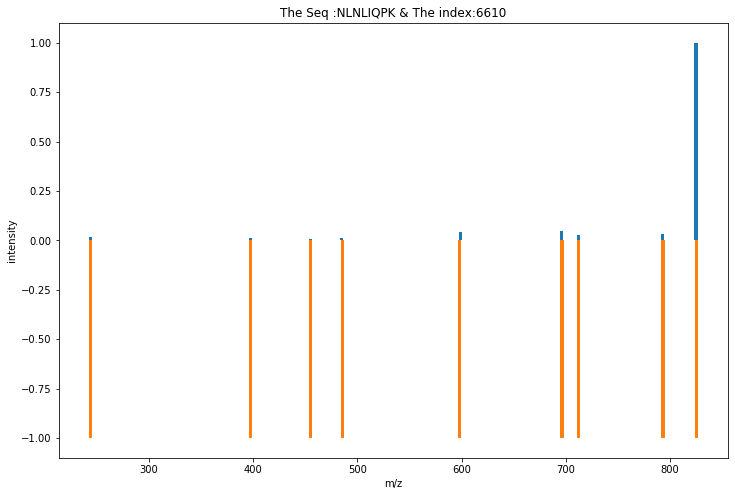

Peptide Index m/z: 10688
 - Peptide hit sequence: ILQESSIAQFDR
Spectrum 1 of ILQESSIAQFDR has 42 peaks.
y1++ is generated at m/z 88.06311469007102
b2++ is generated at m/z 114.091340817671
y2++ is generated at m/z 145.576586769821
y1+ is generated at m/z 175.118952913371
b3++ is generated at m/z 178.120629945271
y3++ is generated at m/z 219.11079391337103
b2+ is generated at m/z 227.175405168571
b4++ is generated at m/z 242.641927056921
y4++ is generated at m/z 283.14008304097104
b5++ is generated at m/z 286.157941636671
y2+ is generated at m/z 290.14589707287104
y5++ is generated at m/z 318.65864012072103
b6++ is generated at m/z 329.673956216421
b3+ is generated at m/z 355.233983423771
y6++ is generated at m/z 375.20067229617104
b7++ is generated at m/z 386.215988391871
y7++ is generated at m/z 418.716686875921
b8++ is generated at m/z 421.734545471621
y3+ is generated at m/z 437.2143113599711
y8++ is generated at m/z 462.232701455671
b4+ is generated at m/z 484.276577647071
b9++ is 

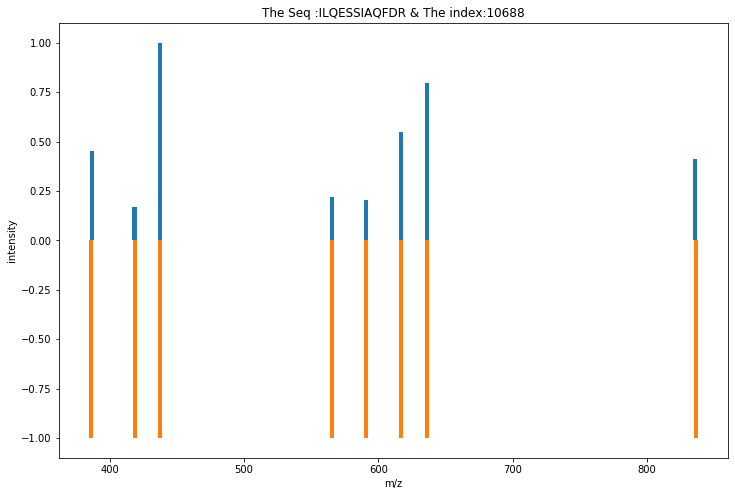

In [4]:
for peptide_id in peptide_ids:
    print (35*"=")
    print ("Peptide Index m/z:", peptide_id.getMetaValue("scan_index"))
    for hit in peptide_id.getHits():
        index=str(peptide_id.getMetaValue("scan_index"))
        seq=str( hit.getSequence())
        print(" - Peptide hit sequence:", hit.getSequence())
        tsg = TheoreticalSpectrumGenerator()
        theo_spec = MSSpectrum()
        p = Param()
        p.setValue("add_y_ions", "true")
        p.setValue("add_b_ions", "true")
        p.setValue("add_metainfo", "true")
        tsg.setParameters(p)
        peptide = AASequence.fromString(hit.getSequence().toString())
        tsg.getSpectrum(theo_spec, peptide, 1, 2)
        # Iterate over annotated ions and their masses
        print("Spectrum 1 of", peptide, "has", theo_spec.size(), "peaks.")
        for ion, peak in zip(theo_spec.getStringDataArrays()[0], theo_spec):
            print(ion.decode(), "is generated at m/z", peak.getMZ())
        exp = MSExperiment()
        MzMLFile().load("y10.mzML", exp)
        spectra = exp.getSpectrum(peptide_id.getMetaValue("scan_index"))
        alignment = []
        spa = SpectrumAlignment()
        p = spa.getParameters()
        # use 0.5 Da tolerance (Note: for high-resolution data we could also use ppm by setting the is_relative_tolerance value to true)
        p.setValue("tolerance", 0.5)
        p.setValue("is_relative_tolerance", "false")
        spa.setParameters(p)
        # align both spectra
        spa.getSpectrumAlignment(alignment, theo_spec, spectra)

        # Print matching ions and mz from theoretical spectrum
        if(len(alignment)!=0):
            print("Number of matched peaks: " + str(len(alignment)))
            print("ion\ttheo. m/z\tobserved m/z")

        
            for theo_idx, obs_idx in alignment:
                ion_name = theo_spec.getStringDataArrays()[0][theo_idx].decode()
                ion_charge = theo_spec.getIntegerDataArrays()[0][theo_idx]
                print(ion_name + "\t" + str(ion_charge) + "\t"
                      + str(theo_spec[theo_idx].getMZ())
                      + "\t" + str(spectra[obs_idx].getMZ()))

            theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
            for theo_idx, obs_idx in alignment:
                theo_mz.append(theo_spec[theo_idx].getMZ())
                theo_int.append(theo_spec[theo_idx].getIntensity())
                obs_mz.append(spectra[obs_idx].getMZ())
                obs_int.append(spectra[obs_idx].getIntensity())
            if(max(obs_int)!=0):
                title ="The Seq :"+ seq+" & The index:"+index
                mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)
        